#**UNIVERSIDADE FEDERAL DO RIO GRANDE DO NORTE (UFRN)**
##**INSTITUTO METRÓPOLE DIGITAL (IMD)**

###**Agrupamento de clientes da base de dados [“Mall Customers”](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python)**

###**Discentes:**
  Claudiano Leonardo da Silva

  Sidney Alves dos Santos Junior

**descrição:**

O objetivo deste trabalho é aplicar técnicas de clustering (agrupamento) para
explorar uma base de dados, identificar padrões e tirar conclusões
interessantes sobre os dados. Devem ser utilizados diferentes algoritmos de
clustering e avaliar o desempenho de cada método.

#Bibliotecas

In [ ]:
!pip install gdown

In [ ]:
import gdown
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.layers import Dense, Input
from keras.models import Model
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

#Pré processamento dos dados

Carregando a base de dados.

In [ ]:
url_dataset = 'https://drive.google.com/file/d/1bL9Uu8XVzP_OeYrkt3a5Yv3Bb0qiNm2r/view?usp=sharing'
output_dataset = '/content/Mall_Customers.csv'
gdown.download(url=url_dataset, output=output_dataset, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1bL9Uu8XVzP_OeYrkt3a5Yv3Bb0qiNm2r
To: /content/Mall_Customers.csv
100%|██████████| 3.98k/3.98k [00:00<00:00, 10.8MB/s]


'/content/Mall_Customers.csv'

In [ ]:
dataset = pd.read_csv(output_dataset)

**CustomerID:** Identificação única do cliente;

**Gender:** Gênero do cliente;

**Age:** Idade do cliente;

**Annual Income:** Renda anual em milhares de dólares;

**Spending Score:** Pontuação de gastos atribuída pelo shopping, baseada
no comportamento do cliente e na natureza dos gastos.

In [ ]:
dataset.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [ ]:
dataset.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


Verificando valores nulos

In [ ]:
dataset.isna().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

Observa-se que *Gender* é um atributo categórico possuindo duas opções (Male ou Female) e pode ser convertido em numérico onde: 1 representa Female e 0 Male, deixando todo o conjunto de dados com o tipo *inteiro*.

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [ ]:
dataset['Gender'] = dataset['Gender'].map({'Male':0, 'Female':1})

In [ ]:
dataset.describe()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,0.560000,38.850000,60.560000,50.200000
std,57.879185,0.497633,13.969007,26.264721,25.823522
min,1.000000,0.000000,18.000000,15.000000,1.000000
25%,50.750000,0.000000,28.750000,41.500000,34.750000
50%,100.500000,1.000000,36.000000,61.500000,50.000000
75%,150.250000,1.000000,49.000000,78.000000,73.000000
max,200.000000,1.000000,70.000000,137.000000,99.000000


Remoção do *CustomerID*, pois o ID do cliente não tem relevância para a nossa análise de padrões, já que não possui informações úteis sobre as características dos clientes.

In [ ]:
dataset = dataset.drop(columns='CustomerID', axis=1)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   Gender                  200 non-null    int64
 1   Age                     200 non-null    int64
 2   Annual Income (k$)      200 non-null    int64
 3   Spending Score (1-100)  200 non-null    int64
dtypes: int64(4)
memory usage: 6.4 KB


Observando os gráficos do tipo *boxplot* e as informações do método *describe()*, concluímos que a base de dados é bem distribuida possuindo somente dois outliers, que no caso são dois cliente que possui um *Annual Income (k$)* maior que os demais clientes.

In [ ]:
def plot_boxplot(x, y):
  sns.set(style="whitegrid")

  fig, axes = plt.subplots(1, 3, figsize=(20, 6))

  for ax, coluna in zip(axes, y):
      sns.boxplot(data=dataset, x=x, y=coluna, ax=ax)
      ax.set_title(f'Boxplot de {coluna} por Gender')
      ax.set_xlabel(x)
      ax.set_ylabel(coluna)

  plt.tight_layout()
  plt.show()

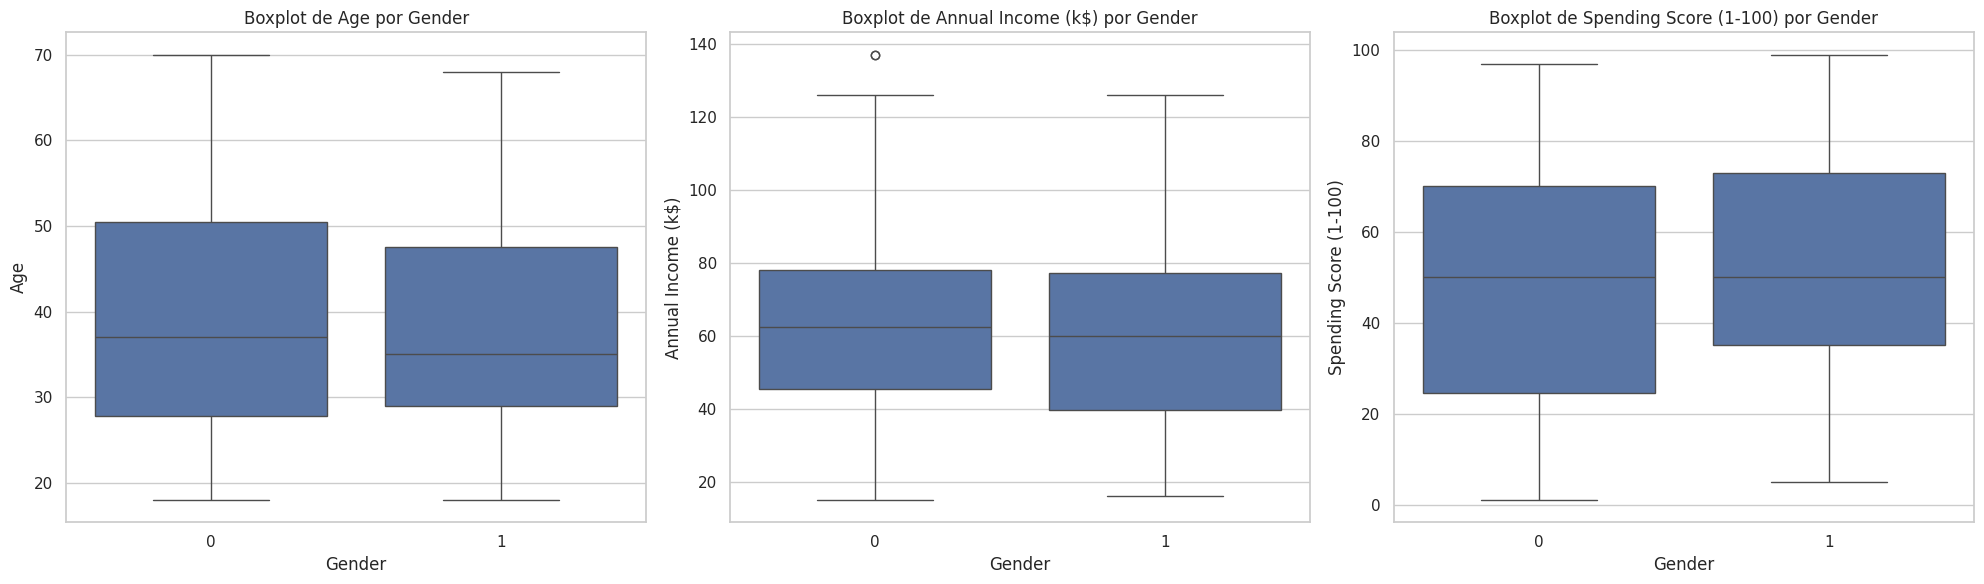

In [ ]:
colunas = ['Age','Annual Income (k$)','Spending Score (1-100)']

plot_boxplot('Gender', colunas)

In [ ]:
dataset[dataset['Annual Income (k$)'] == 137]

,Gender,Age,Annual Income (k$),Spending Score (1-100)
198,0,32,137,18
199,0,30,137,83


In [ ]:
#dataset = dataset.drop(dataset.index[dataset['Annual Income (k$)'] == 137].to_list(),axis=0)
#dataset[dataset['Annual Income (k$)'] == 137]

In [ ]:
#plot_boxplot('Gender', colunas)

In [ ]:
#dataset.describe()

In [ ]:
scaler = StandardScaler()
dataset_normalizado = scaler.fit_transform(dataset)

In [ ]:
dataset_normalizado.min(), dataset_normalizado.max()

(-1.9100207870073291, 2.9176711658902788)

In [ ]:
dataset_normalizado.shape

(200, 4)

#PCA para visualização dos dados

É utilizada a técnica de PCA para reduzir a dimensão dos dados de forma que possamos vizualizar graficamente.

In [ ]:
pca = PCA(n_components=2)
dataset_pca = pca.fit_transform(dataset_normalizado)

In [ ]:
dataset_pca = pd.DataFrame(data=dataset_pca, columns=['C1', 'C2'])
dataset_pca.head()

,C1,C2
0,-0.406383,-0.520714
1,-1.427673,-0.367310
2,0.050761,-1.894068
3,-1.694513,-1.631908
4,-0.313108,-1.810483


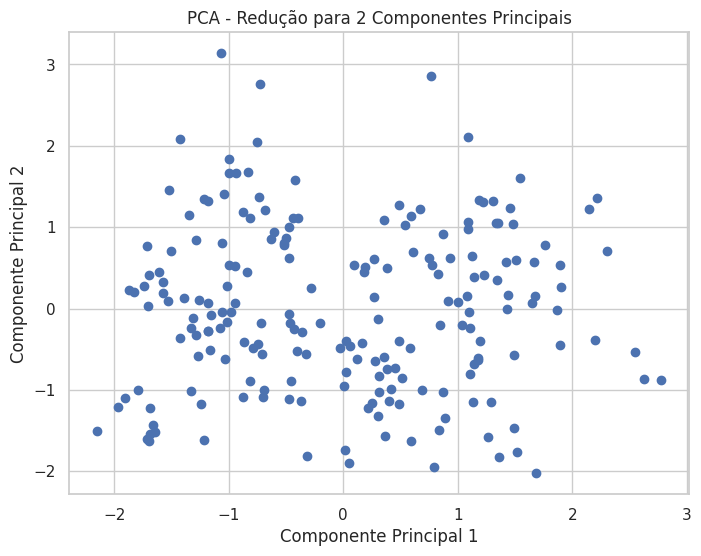

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(dataset_pca['C1'], dataset_pca['C2'])
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA - Redução para 2 Componentes Principais')
plt.show()

#Modelos de agrupamento

##K-Means

O K-Means é um algoritmo de agrupamento simples e popular usado para dividir um conjunto de dados em k clusters.

1. Inicialização:
* Escolher o número de clusters k desejado.
* Inicialar k centróides (os pontos centrais dos clusters), que podem ser escolhidos aleatoriamente entre os pontos de dados ou usando métodos como K-Means++ para uma inicialização mais eficiente.

2. Atribuição de Pontos aos Clusters:
* Para cada ponto de dado, calcular a distância (geralmente a distância euclidiana) entre o ponto e cada um dos k centróides.
* Atribuir o ponto ao cluster cujo centróide esteja mais próximo.

3. Recalcular os Centròides e Repetir:
* Após atribuir todos os pontos aos clusters, recalculare os centróides dos clusters. O novo centróide de cada cluster é a média de todos os pontos atribuídos a esse cluster.

* Repita os passos 2 e 3 até que a atribuição dos pontos aos clusters não mude mais, ou até que o deslocamento dos centróides seja menor que um limiar definido (convergência).

Escolhendo quantidade de grupos para realizar testes e observar em quantos grupos os dados tendem a serem compactados.

In [ ]:
ks = range(1, 9)

É observado que em 2, 4 e 8 grupos os dados estão mais relacionados devido a mudança de comportamento.

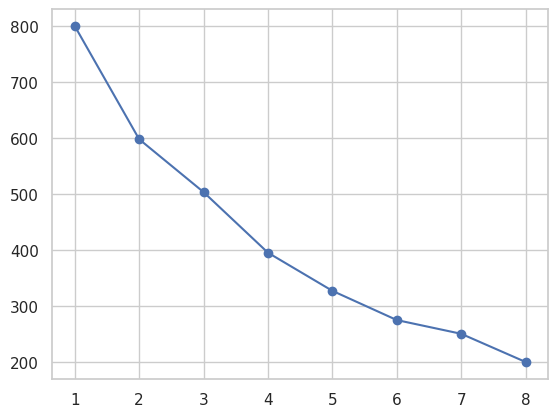

In [ ]:
inertias = []

for k in ks:
  km = KMeans(n_clusters=k, init='k-means++' , random_state=0, n_init='auto')
  km.fit(dataset_normalizado)
  inertias.append(km.inertia_)

plt.plot(ks, inertias, marker='o')

Observando pela diferença percentual, fica mais evidente que os dados tendem a formarem 2, 4 ou 8 grupos.

Uma observação é que ao escolher 4 grupos, seria como realizar a separação de $k=2$ em 2 novos grupos para cada agrupamento. Assim como em $k=4$ há uma separação em 2 grupos para cada agrupamento.

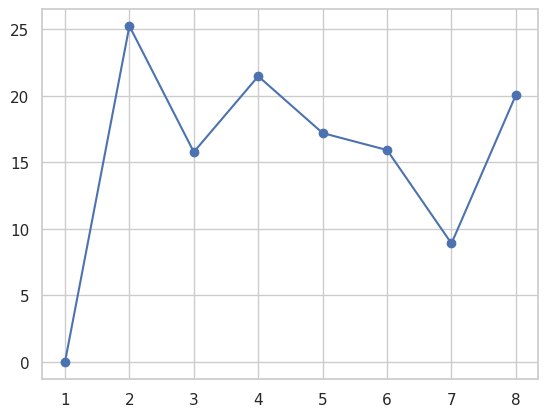

In [ ]:
diff = [(1 - (inertias[i] / inertias[i-1]))*100 if i > 0 else 0 for i in range(0,len(inertias))]
plt.plot(range(1,len(diff)+1), diff, marker='o')

Aplicando K-Means para $k=2$

In [ ]:
km = KMeans(n_clusters=2, init='k-means++' , random_state=0, n_init='auto')
km.fit(dataset_normalizado)
kmeans_clusters = km.fit_predict(dataset_normalizado)

In [ ]:
dataset_kmeans = dataset_pca.copy()
dataset_kmeans['Cluster'] = km.labels_
centroides = km.cluster_centers_

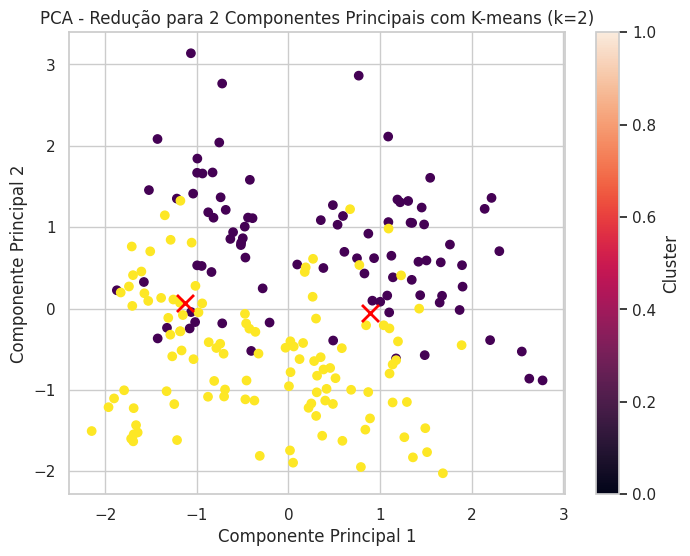

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(dataset_kmeans['C1'], dataset_kmeans['C2'], c=dataset_kmeans['Cluster'], cmap='viridis', marker='o')
plt.scatter(centroides[:, 0], centroides[:, 1], marker='x', s=150, color='red', linewidths=2, label='Centroides')

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA - Redução para 2 Componentes Principais com K-means (k=2)')
plt.colorbar(label='Cluster')
plt.show()

## Agrupamento Hierárquico

O agrupamento hierárquico é um método de clustering que visa construir uma hierarquia de clusters. Existem dois tipos principais: aglomerativo (bottom-up) e divisivo (top-down).

1. Aglomerativo (Bottom-Up)
* Começa com cada ponto de dado em seu próprio cluster, resultando em tantos clusters quanto pontos.

* Encontre os dois clusters mais próximos e os una em um único cluster.
  * Single linkage (ligação simples): A distância mínima entre pontos de dois clusters.
  * Complete linkage (ligação completa): A distância máxima entre pontos de dois clusters.
  * Average linkage (ligação média): A média das distâncias entre todos os pontos de dois clusters.
  * Centroid linkage (ligação centróide): A distância entre os centróides dos clusters.
* Repitir até que todos os pontos estejam em um único cluster ou até atingir um critério de parada definido (por exemplo, um número desejado de clusters).

2. Divisivo (Top-Down)
* Começa com todos os pontos em um único cluster.
* Iterativamente, dividir o cluster mais heterogêneo (ou grande) em dois subclusters até que cada ponto esteja em seu próprio cluster ou até atingir um critério de parada.

**Dendograma**

O resultado do agrupamento hierárquico pode ser representado visualmente usando um dendrograma, que é uma árvore que mostra a ordem das fusões ou divisões. Cada nível do dendrograma representa uma fusão ou divisão de clusters, e a altura da fusão/divisão indica a distância entre os clusters.

Aplicando o Agrupamento Hierárquico

In [ ]:
agglo = AgglomerativeClustering(n_clusters=2)
agglo_clusters = agglo.fit_predict(dataset_normalizado)

In [ ]:
similarity_distance = 1 - cosine_similarity(dataset_normalizado)
Z = linkage(similarity_distance, method='ward')

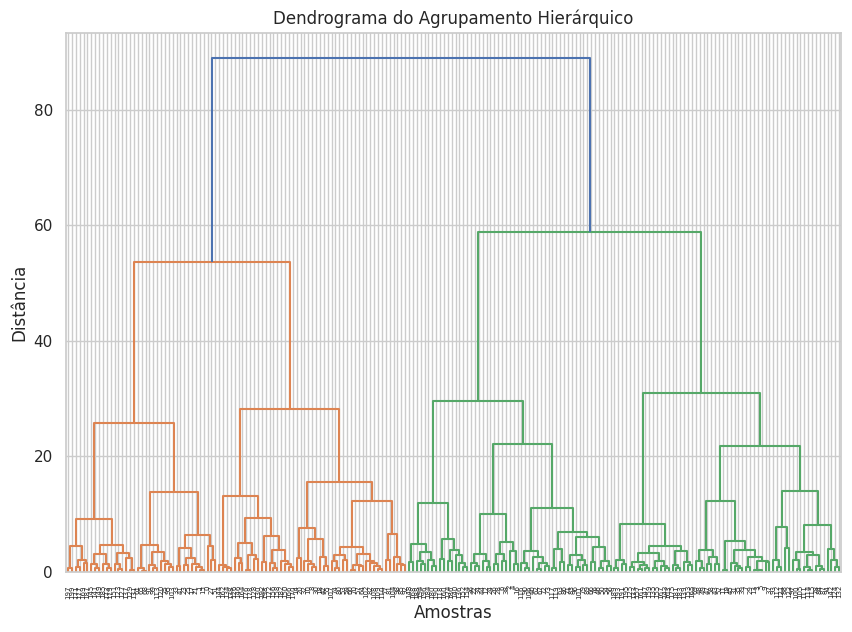

In [ ]:
plt.figure(figsize=(10, 7))
dendrogram(Z, leaf_rotation=90)
plt.title('Dendrograma do Agrupamento Hierárquico')
plt.xlabel('Amostras')
plt.ylabel('Distância')
plt.show()

## Agrupamento Espectral

O agrupamento espectral é um método de clustering que utiliza técnicas de álgebra linear, especialmente valores próprios (Autovalores) e vetores próprios (Autovetores), para realizar o agrupamento de dados. Este método é particularmente útil para detectar clusters de formas complexas e não esféricas.

1. Construção do Grafo de Similaridade:
* Os dados são representados como um grafo onde cada ponto de dado é um nó.
* As arestas entre os nós são ponderadas de acordo com a similaridade entre os pontos de dados. A similaridade pode ser medida de várias maneiras, como a distância euclidiana ou outras métricas de proximidade. A matriz de adjacência
$W$ armazena essas similaridades.

2. Construção da Matriz Laplaciana:
* A partir da matriz de adjacência $W$, constrói-se a matriz Laplaciana $L$. Definição da matriz Laplaciana:
  * $L = D - W$
* onde $D$ é a matriz diagonal de graus, com $D_{ii}$ sendo a soma dos pesos das arestas conectadas ao nó $i$.

3. Cálculo dos Vetores Próprios:
* Calcule os primeiros $k$ vetores próprios (Autovetores) da matriz Laplaciana $L$, correspondentes aos menores $k$ valores próprios (Autovalores). Esses vetores próprios formam uma nova representação dos dados em um espaço de menor dimensão.

4. Agrupamento no Espaço de Vetores Próprios:
* Os dados transformados pelos $k$ vetores próprios são agora agrupados usando um algoritmo de clustering tradicional, como o K-Means. Cada ponto de dado é representado por suas coordenadas nesses $k$ vetores próprios.

In [ ]:
spectral = SpectralClustering(n_clusters=2, assign_labels='kmeans', random_state=0)
clusters_spectral = spectral.fit_predict(dataset_normalizado)

In [ ]:
dataset_sc = dataset_pca.copy()
dataset_sc['Cluster'] = clusters_spectral

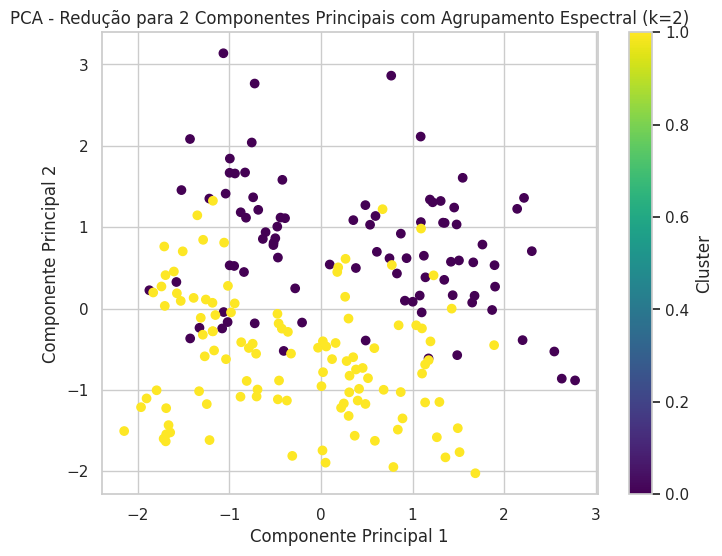

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(dataset_sc['C1'], dataset_sc['C2'], c=dataset_sc['Cluster'], cmap='viridis', marker='o')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA - Redução para 2 Componentes Principais com Agrupamento Espectral (k=2)')
plt.colorbar(label='Cluster')
plt.show()

#Métricas de avaliação

Para avaliar a qualidade dos clusters formados pelos algoritmos de clustering, utilizamos três métricas comuns: Silhouette Score, Calinski-Harabasz Score e Davies-Bouldin Score.

1. Silhouette Score:

  O Silhouette Score mede quão similar um ponto é ao seu próprio cluster em comparação com outros clusters. Ele varia de -1 a 1, onde um valor próximo de 1 indica que os pontos estão bem agrupados dentro dos seus clusters e bem separados de outros clusters. Um valor próximo de 0 indica que os pontos estão em uma fronteira entre clusters, e um valor negativo indica que os pontos podem ter sido atribuídos ao cluster errado.

2. Calinski-Harabasz Score:

  ambém conhecido como critério de variação entre e dentro dos clusters, o Calinski-Harabasz Score avalia a razão entre a soma da dispersão entre os clusters e a soma da dispersão dentro dos clusters. Um valor maior indica uma melhor definição dos clusters.

3. Davies-Bouldin Score:

  O Davies-Bouldin Score mede a média das razões de similaridade intra-cluster e separação inter-cluster para cada cluster. Quanto menor o valor, melhor a separação dos clusters.

In [ ]:
clusters_list = {'K-means':kmeans_clusters, 'Agrupamento Hierárquico':agglo_clusters, 'Agrupamento Espectral':clusters_spectral}

In [ ]:
def evaluate_clusters(data, labels):
    silhouette = silhouette_score(data, labels)
    calinski = calinski_harabasz_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)
    return silhouette, calinski, davies_bouldin

1. Silhouette Score:

  K-Means e Agrupamento Espectral apresentam o mesmo valor de Silhouette Score (0.2776), indicando que ambos os métodos têm um desempenho semelhante em termos de coesão e separação dos clusters.

2. Calinski-Harabasz Score:

  O Agrupamento Hierárquico tem o valor mais alto (67.0422), indicando que os clusters formados por este método são mais distintos uns dos outros.

3. Davies-Bouldin Score:

  K-Means e Agrupamento Espectral têm o mesmo valor de Davies-Bouldin Score (1.6117), indicando que ambos os métodos formam clusters que são mais separados uns dos outros.

In [ ]:
for modelo_nome, modelo_predict in clusters_list.items():
  silhouette, calinski, davies_bouldin = evaluate_clusters(dataset_normalizado, modelo_predict)
  print(f'Modelo: {modelo_nome}')
  print(f"Silhouette Score: {silhouette}")
  print(f"Calinski-Harabasz Score: {calinski}")
  print(f"Davies-Bouldin Score: {davies_bouldin}\n")

Modelo: K-means
Silhouette Score: 0.2776035125578272
Calinski-Harabasz Score: 66.90629131398856
Davies-Bouldin Score: 1.6116938570457684

Modelo: Agrupamento Hierárquico
Silhouette Score: 0.24177953745462927
Calinski-Harabasz Score: 67.04224546779565
Davies-Bouldin Score: 1.6611081566968284

Modelo: Agrupamento Espectral
Silhouette Score: 0.2776035125578272
Calinski-Harabasz Score: 66.90629131398856
Davies-Bouldin Score: 1.6116938570457684



**K-Means e Agrupamento Espectral:**

Apresentaram resultados idênticos para todas as métricas, indicando que ambos os métodos são igualmente eficazes para este conjunto de dados. Eles formam clusters que são bem coesos e bem separados.

Ambos são boas opções, mas em casos de dados não linearmente separáveis e/ou complexos, o agrupamento espectral é a melhor opção.